# Comparison of McBEF vs Classic Plume Rise Simulations

This notebook compares the resulting Plume Rise simulations.

* Freitas PR model with McBEF flaming heat flux
* Freitas PR model with classical heat flux assumptions implemented in plumerise.bioma

Notice that the classic flaming heatfluxes and the fraction of flaming/smoldering fires are prescribed as a function of biome type.

In [1]:
import os
import sys

#import importlib
#importlib.reload(kde)

from IPython.display import display, Markdown

import numpy as np
import xarray as xr
from datetime import datetime, timedelta

from pyobs     import mcbef as mb
from pyobs     import kde
from plumerise import bioma as bm

import matplotlib.pyplot as plt
%matplotlib inline 

lb, mode, ub = (0, 1, 2)  # indices for McBEF stats


## Load data

In [2]:
def getFiresMetOneDay(day,Verbose=False):
    """
    Ingests McBEF retrievals and sampled meteorology for one day.
    """

    l2_dirn = '/css/viirs/data/Level2/VNP47MCBEF/2019/'
    f_fname = l2_dirn + 'VNP47MCBEF.Stats.A2019%03d.0000_2400.Uniform_v_1_0_0.nc'%day
    m_fname = l2_dirn + 'VNP47MCBEF.Met.A2019%03d.nc'%day
    p_fname = './VNP47MCBEF.PR.A2019%03d.nc'%day
    p_20ha_fname = './VNP47MCBEF.PR_20ha.A2019%03d.nc'%day
    
    f = mb.open_dataset(f_fname) # fire property statistics
    m = xr.open_dataset(m_fname) # sample met fields
    p = xr.open_dataset(p_fname)
    p_20ha = xr.open_dataset(p_20ha_fname)
        
    # Only good QA
    # ------------
    N = f.dims['fire']
    I = (f.QA_flag<mb.QA['Bowtie'])
    J = np.arange(N,dtype=int)[I]
    f = f.isel(fire=J)
    m = m.isel(time=J)
    
    failed = int(0.5 + 100 * (N - f.dims['fire']) / N)
    
    if p.dims['time'] != m.dims['time']:
        raise ValueError("Inconsistent pr/met dimensions: %d %d"%(p.dims['time'],m.dims['time']))
     
    # Only cases that the PR model was able to determine a plume
    # ----------------------------------------------------------
    I = (p.z_f)>0&(p_20ha.z_f>0)
    N = f.dims['fire']
    J = np.arange(N,dtype=int)[I]
    f = f.isel(fire=J)
    m = m.isel(time=J)
    p = p.isel(time=J)
    p_20ha = p_20ha.isel(time=J)
    
    # Biome Types using FILDA provided vegetation types
    # -------------------------------------------------
    bf = bm.getAggregateBiome ( f.FP_Land_Type, f.FP_Latitude)
    
    if Verbose:
        display(Markdown("**FIRE PROPERTIES**"),f)
        display(Markdown("**SAMPLED METEOROLOGY**"),m)
        display(Markdown("**PLUME RISE**"),p)
    
    return f, bf, m, p, p_20ha, failed
                      

## Compute KDE of Plume Rise Properties

In [3]:
def prop_KDE(b,biome,X,P,N=256,range=None):
    """
    Accumulates KDE of X.
    """
    
    if len(X.shape) == 2:
        P_ = np.zeros((3,N))
        I = (b==biome)&(np.isnan(X[:,1])==False)
        bins, P_[0,:] = kde.calc_kde1d(X[I,0],range=range)
        bins, P_[1,:] = kde.calc_kde1d(X[I,1],range=range)
        bins, P_[2,:] = kde.calc_kde1d(X[I,2],range=range)
    else:
        P_ = np.zeros(N)
        I = (b==biome)&(np.isnan(X)==False)
        bins, P_ = kde.calc_kde1d(X[I],N=N,range=range)
     
    P += P_                
                      
    return (bins,P)
                     

In [4]:
N = 256  # number of KDE bins

# KDE
# ---
Z_I, Z_D, Z_A, Z_F = np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N))
Z_I_20ha, Z_D_20ha, Z_A_20ha, Z_F_20ha = np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N))

nZ_I, nZ_D, nZ_A, nZ_F = np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N))
nZ_I_20ha, nZ_D_20ha, nZ_A_20ha, nZ_F_20ha = np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N))

PBLH = np.zeros((4,N))
MCE, P_MCE, P_1mMCE = np.zeros((4,N))


# Loop over days...
ndays = 0
oneday = timedelta(seconds=24*60*60)
date0 = datetime(2018,12,31)
for day in range(182,305):
#for day in [182,183]:

    # Skip problem days...
    # --------------------
    if day in [205, 226, 265, 269, 272, 274, 288, 289]:
        continue
    

    # Load fires and met fields
    # -------------------------
    (f, bf, m, p, p_20ha, failed)  = getFiresMetOneDay(day,Verbose=False)
    
    date_ = (date0+day*oneday).date()
    if day%4 == 0: print('| Day',date_,'with',f.dims['fire'],'fires(',failed,'% failed)',end='\r')
    if day%4 == 1: print('/ Day',date_,'with',f.dims['fire'],'fires(',failed,'% failed)',end='\r')
    if day%4 == 2: print('- Day',date_,'with',f.dims['fire'],'fires(',failed,'% failed)',end='\r')
    if day%4 == 3: print('\ Day',date_,'with',f.dims['fire'],'fires(',failed,'% failed)',end='\r') 
    
    ndays += 1
    
    # Estimate KDE
    # ------------
    for b in range(4):
        
        ratio = p.z_f.values / m.PBLH.values
        ratio_20ha = p_20ha.z_f.values / m.PBLH.values   

        bins_P,   PBLH[b] = prop_KDE(bf, b+1, m.PBLH/1000., PBLH[b], range=(0,1.5))
        bins_M,   MCE[b]  = prop_KDE(bf, b+1, f.FP_MCE,     MCE[b],  range=(0,1))
            
        bins_F,   Z_F[b] = prop_KDE(bf, b+1, p.z_f/1000.,   Z_F[b], range=(0,15))
        bins_F,   Z_F_20ha[b] = prop_KDE(bf, b+1, p_20ha.z_f/1000.,   Z_F_20ha[b], range=(0,15))
        
        bins_nF, nZ_F[b] = prop_KDE(bf, b+1, ratio, nZ_F[b], range=None)
        bins_nF, nZ_F_20ha[b] = prop_KDE(bf, b+1, ratio_20ha, nZ_F_20ha[b], range=None)
        

            
# Normalize
# ---------
for P in [ PBLH, 
           MCE,
          Z_F, 
          nZ_F, 
          Z_F_20ha, 
          nZ_F_20ha,]:
    P = P / ndays
    
# Save it for later
# -----------------
f_npz = './VNP47MCBEF.PR_KDE.npz'
np.savez(f_npz,
         bins_F=bins_F, 
         bins_P=bins_P,
         PBLH=PBLH,
         MCE=MCE,
         Z_F=Z_F,
         nZ_F=nZ_F,
         Z_F_20ha=Z_F_20ha,
         nZ_F_20ha=nZ_F_20ha,         
        )
             
    

## Plotting Mean KDEs for each Aggregated Biome
Next we plot the mean KDEs for each biome

In [5]:
f_npz = './VNP47MCBEF.PR_KDE.npz'
f = np.load(f_npz)  # retrieve KDEs from disk
for v_ in f.keys():
    setattr(sys.modules[__name__], v_, f[v_])

## Plume Rise, VMD Parameters

In [6]:
def plot_Prop(bins,title,xlabel,X1,lab1='',X2=None,lab2=''):   
    plt.plot(bins,X1,'b',label=lab1) 
    if X2 is not None:
        plt.plot(bins,X2,'r',label=lab2) 
        plt.legend(loc='upper right')
    plt.grid(), plt.xlabel(xlabel),plt.ylabel('p.d.f'),plt.title(title)
def plot_Prop1(bins,X,title,xlabel):
    plot_Prop(bins,title,xlabel,X)
def plot_Prop2(bins,X1,lab1,X2,lab2,title,xlabel):
    plot_Prop(bins,title,xlabel,X1,lab1=lab1,X2=X2,lab2=lab2)

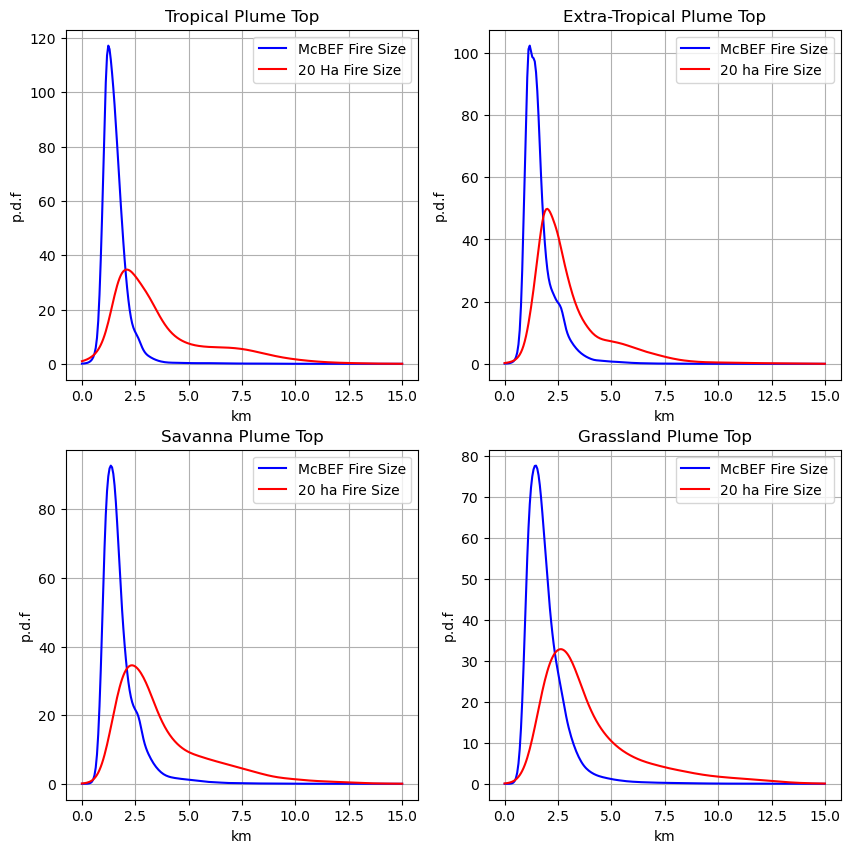

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop2(bins_F,Z_F[0],'McBEF Fire Size',Z_F_20ha[0],'20 Ha Fire Size','Tropical Plume Top', 'km')
plt.subplot(222)
plot_Prop2(bins_F,Z_F[1],'McBEF Fire Size',Z_F_20ha[1],'20 ha Fire Size','Extra-Tropical Plume Top', 'km')
plt.subplot(223)
plot_Prop2(bins_F,Z_F[2],'McBEF Fire Size',Z_F_20ha[2],'20 ha Fire Size','Savanna Plume Top', 'km')
plt.subplot(224)
plot_Prop2(bins_F,Z_F[3],'McBEF Fire Size',Z_F_20ha[3],'20 ha Fire Size','Grassland Plume Top', 'km')

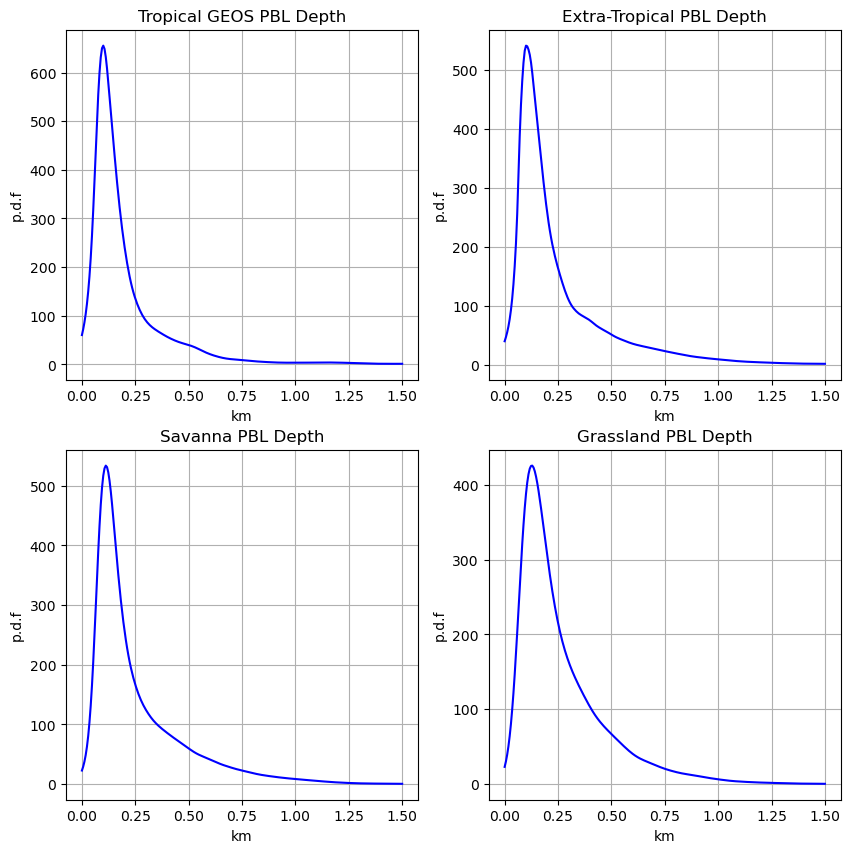

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop1(bins_P,PBLH[0],'Tropical GEOS PBL Depth', 'km')
plt.subplot(222)
plot_Prop1(bins_P,PBLH[1],'Extra-Tropical PBL Depth', 'km')
plt.subplot(223)
plot_Prop1(bins_P,PBLH[2],'Savanna PBL Depth', 'km')
plt.subplot(224)
plot_Prop1(bins_P,PBLH[3],'Grassland PBL Depth', 'km')

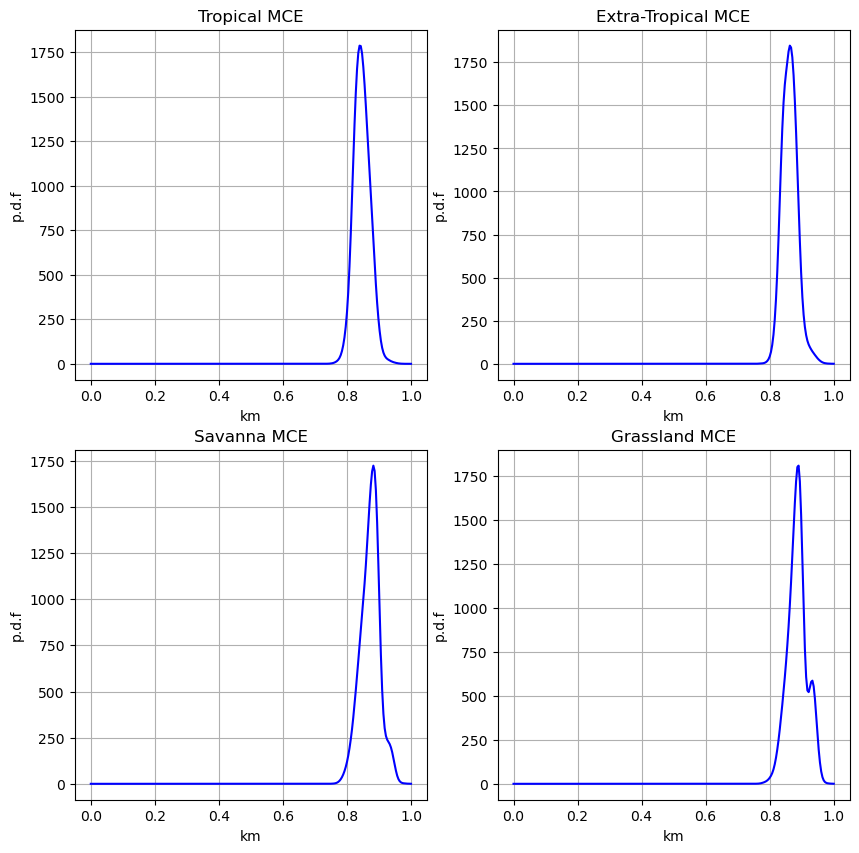

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop1(bins_M,MCE[0],'Tropical MCE', 'km')
plt.subplot(222)
plot_Prop1(bins_M,MCE[1],'Extra-Tropical MCE', 'km')
plt.subplot(223)
plot_Prop1(bins_M,MCE[2],'Savanna MCE', 'km')
plt.subplot(224)
plot_Prop1(bins_M,MCE[3],'Grassland MCE', 'km')

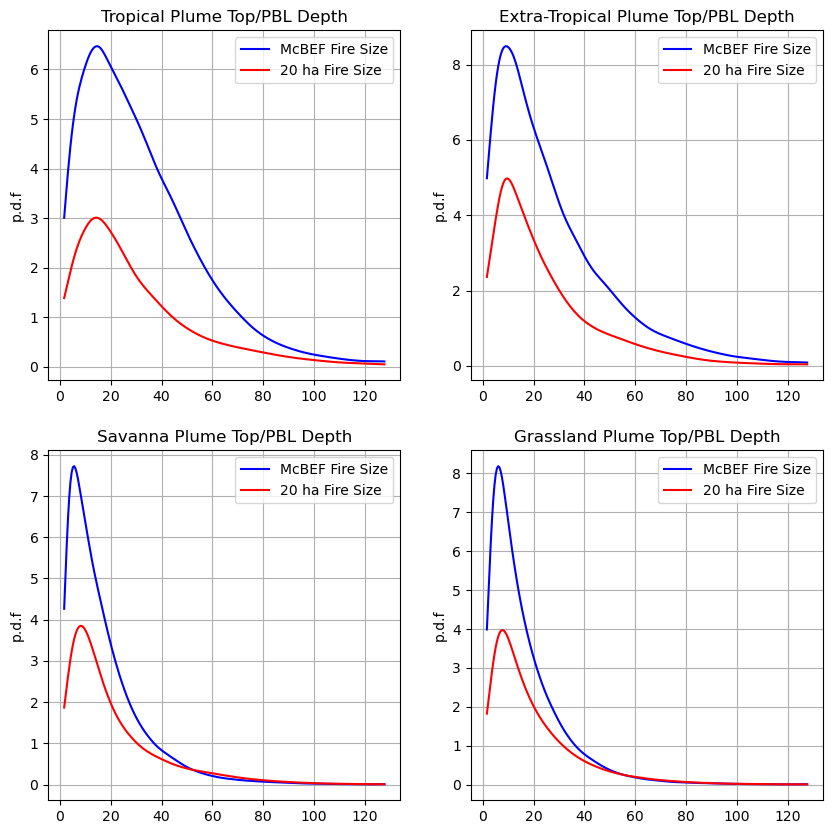

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop2(bins_nF,nZ_F[0],'McBEF Fire Size',nZ_F_20ha[0],'20 ha Fire Size','Tropical Plume Top/PBL Depth', '')
plt.subplot(222)
plot_Prop2(bins_nF,nZ_F[1],'McBEF Fire Size',nZ_F_20ha[1],'20 ha Fire Size','Extra-Tropical Plume Top/PBL Depth', '')
plt.subplot(223)
plot_Prop2(bins_nF,nZ_F[2],'McBEF Fire Size',nZ_F_20ha[2],'20 ha Fire Size','Savanna Plume Top/PBL Depth', '')
plt.subplot(224)
plot_Prop2(bins_nF,nZ_F[3],'McBEF Fire Size',nZ_F_20ha[3],'20 ha Fire Size','Grassland Plume Top/PBL Depth', '')

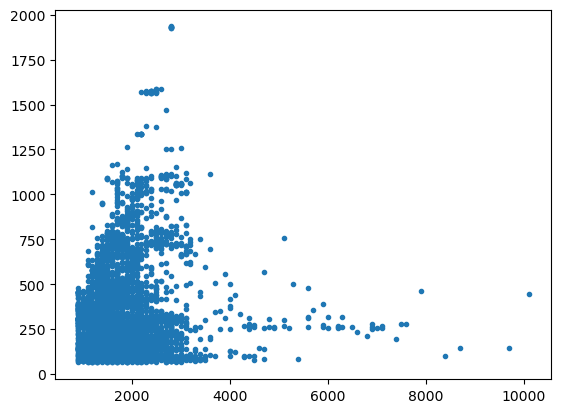

In [11]:
plt.plot(p.z_f,m.PBLH,'.')

In [12]:
f

NpzFile './VNP47MCBEF.PR_KDE.npz' with keys: bins_F, bins_P, PBLH, MCE, Z_F...